In [1]:
!pip install pyspark

In [2]:
import pyspark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = "SimHei" #解决中文乱码问题
import seaborn as sns
import random

# 导入数据

In [3]:
infoPath="~/IdeaProjects/Spark/SparkTask1/data/user_info_format1.csv"
logPath="~/IdeaProjects/Spark/SparkTask1/data/user_log_format1.csv"
testPath="~/IdeaProjects/Spark/SparkTask1/data/test_format1.csv"
trainPath="~/IdeaProjects/Spark/SparkTask1/data/train_format1.csv"

In [4]:
user_info=pd.read_csv(infoPath)
user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [5]:
user_log=pd.read_csv(logPath)
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


In [6]:
train_data=pd.read_csv(trainPath)
train_data.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [26]:
test_data=pd.read_csv(testPath)
test_data.head()

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


# 缺失值处理

In [7]:
user_info['age_range'].replace(0.0,np.nan,inplace=True)
user_info['gender'].replace(2.0,np.nan,inplace=True)
user_info['age_range'].replace(np.nan,-1,inplace=True)
user_info['gender'].replace(np.nan,-1,inplace=True)

# 绘图查看数据特征

Text(0.5, 1.0, 'User age range')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


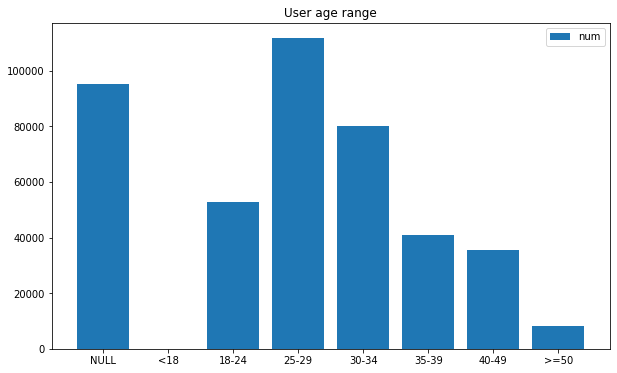

In [8]:
fig = plt.figure(figsize = (10, 6))
x = np.array(["NULL","<18","18-24","25-29","30-34","35-39","40-49",">=50"])
#<18岁为1；[18,24]为2； [25,29]为3； [30,34]为4；[35,39]为5；[40,49]为6； > = 50时为7和8
y = np.array([user_info[user_info['age_range'] == -1]['age_range'].count(),
             user_info[user_info['age_range'] == 1]['age_range'].count(),
             user_info[user_info['age_range'] == 2]['age_range'].count(),
             user_info[user_info['age_range'] == 3]['age_range'].count(),
             user_info[user_info['age_range'] == 4]['age_range'].count(),
             user_info[user_info['age_range'] == 5]['age_range'].count(),
             user_info[user_info['age_range'] == 6]['age_range'].count(),
             user_info[user_info['age_range'] == 7]['age_range'].count() + user_info[user_info['age_range'] == 8]['age_range'].count()])
plt.bar(x,y,label='num')
plt.legend()
plt.title('User age range')

Text(0.5, 1.0, 'User age_range')

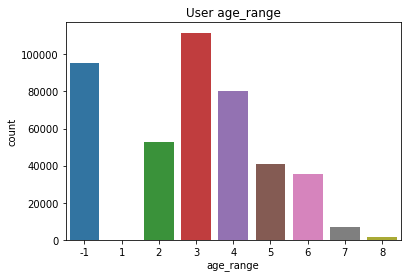

In [9]:
sns.countplot(x = 'age_range', order = [-1,1,2,3,4,5,6,7,8], data = user_info)
plt.title('User age_range')

Text(0.5, 1.0, 'User gender')

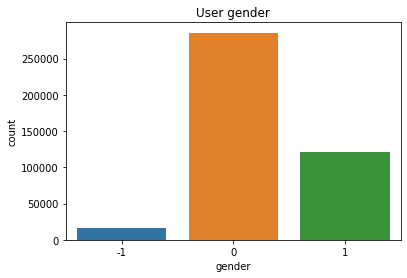

In [10]:
sns.countplot(x='gender',order = [-1,0,1],data = user_info)
plt.title('User gender')

Text(0.5, 1.0, 'User age and gender')

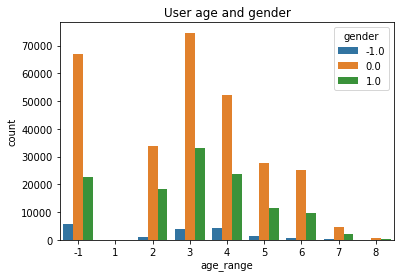

In [11]:
sns.countplot(x = 'age_range', order = [-1,1,2,3,4,5,6,7,8],hue= 'gender',data = user_info)
plt.title('User age and gender')

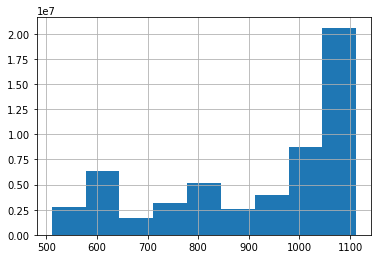

In [12]:
user_log['time_stamp'].hist(bins = 9)

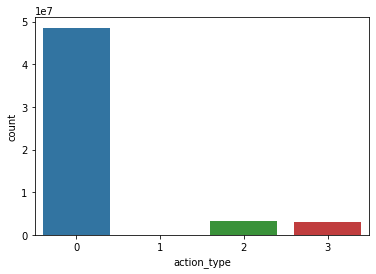

In [13]:
sns.countplot(x = 'action_type', order = [0,1,2,3],data = user_log)

# 特征工程

In [14]:
train_data = pd.merge(train_data,user_info,on="user_id",how="left")

In [33]:
test_data = pd.merge(test_data,user_info,on="user_id",how="left")

In [15]:
total_logs_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"]]).count().reset_index()[["user_id","seller_id","item_id"]]
total_logs_temp.rename(columns={"seller_id":"merchant_id","item_id":"total_logs"},inplace=True)
#total_logs_temp.head()

In [16]:
train_data=pd.merge(train_data,total_logs_temp,on=["user_id","merchant_id"],how='left')
train_data.head()

,user_id,merchant_id,label,age_range,gender,total_logs
0,34176,3906,0,6.0,0.0,39
1,34176,121,0,6.0,0.0,14
2,34176,4356,1,6.0,0.0,18
3,34176,2217,0,6.0,0.0,2
4,230784,4818,0,-1.0,0.0,8


In [34]:
test_data=pd.merge(test_data,total_logs_temp,on=["user_id","merchant_id"],how='left')
test_data.head()

,user_id,merchant_id,prob,age_range,gender,total_logs
0,163968,4605,NaN,-1.0,0.0,2
1,360576,1581,NaN,2.0,-1.0,10
2,98688,1964,NaN,6.0,0.0,6
3,98688,3645,NaN,6.0,0.0,11
4,295296,3361,NaN,2.0,1.0,50


In [17]:
unique_item_ids_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"],user_log["item_id"]]).count().reset_index()[["user_id","seller_id","item_id"]]
unique_item_ids_temp1 = unique_item_ids_temp.groupby([unique_item_ids_temp["user_id"],unique_item_ids_temp["seller_id"]]).count().reset_index()
unique_item_ids_temp1.rename(columns={"seller_id":"merchant_id","item_id":"unique_item_ids"},inplace=True)
#unique_item_ids_temp1.head()

In [18]:
train_data=pd.merge(train_data,unique_item_ids_temp1,on=["user_id","merchant_id"],how='left')
train_data.head()

,user_id,merchant_id,label,age_range,gender,total_logs,unique_item_ids
0,34176,3906,0,6.0,0.0,39,20
1,34176,121,0,6.0,0.0,14,1
2,34176,4356,1,6.0,0.0,18,2
3,34176,2217,0,6.0,0.0,2,1
4,230784,4818,0,-1.0,0.0,8,1


In [35]:
test_data=pd.merge(test_data,unique_item_ids_temp1,on=["user_id","merchant_id"],how='left')
test_data.head()

,user_id,merchant_id,prob,age_range,gender,total_logs,unique_item_ids
0,163968,4605,NaN,-1.0,0.0,2,1
1,360576,1581,NaN,2.0,-1.0,10,9
2,98688,1964,NaN,6.0,0.0,6,1
3,98688,3645,NaN,6.0,0.0,11,1
4,295296,3361,NaN,2.0,1.0,50,8


In [19]:
categories_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"],user_log["cat_id"]]).count().reset_index()[["user_id","seller_id","cat_id"]]
categories_temp1 = categories_temp.groupby([categories_temp["user_id"],categories_temp["seller_id"]]).count().reset_index()
categories_temp1.rename(columns={"seller_id":"merchant_id","cat_id":"categories"},inplace=True)
train_data=pd.merge(train_data,categories_temp1,on=["user_id","merchant_id"],how='left')
train_data.head()

,user_id,merchant_id,label,age_range,gender,total_logs,unique_item_ids,categories
0,34176,3906,0,6.0,0.0,39,20,6
1,34176,121,0,6.0,0.0,14,1,1
2,34176,4356,1,6.0,0.0,18,2,1
3,34176,2217,0,6.0,0.0,2,1,1
4,230784,4818,0,-1.0,0.0,8,1,1


In [36]:
test_data=pd.merge(test_data,categories_temp1,on=["user_id","merchant_id"],how='left')
test_data.head()

,user_id,merchant_id,prob,age_range,gender,total_logs,unique_item_ids,categories
0,163968,4605,NaN,-1.0,0.0,2,1,1
1,360576,1581,NaN,2.0,-1.0,10,9,4
2,98688,1964,NaN,6.0,0.0,6,1,1
3,98688,3645,NaN,6.0,0.0,11,1,1
4,295296,3361,NaN,2.0,1.0,50,8,4


In [20]:
browse_days_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"],user_log["time_stamp"]]).count().reset_index()[["user_id","seller_id","time_stamp"]]
browse_days_temp1 = browse_days_temp.groupby([browse_days_temp["user_id"],browse_days_temp["seller_id"]]).count().reset_index()
browse_days_temp1.rename(columns={"seller_id":"merchant_id","time_stamp":"browse_days"},inplace=True)
train_data=pd.merge(train_data,browse_days_temp1,on=["user_id","merchant_id"],how='left')
train_data.head()

,user_id,merchant_id,label,age_range,gender,total_logs,unique_item_ids,categories,browse_days
0,34176,3906,0,6.0,0.0,39,20,6,9
1,34176,121,0,6.0,0.0,14,1,1,3
2,34176,4356,1,6.0,0.0,18,2,1,2
3,34176,2217,0,6.0,0.0,2,1,1,1
4,230784,4818,0,-1.0,0.0,8,1,1,3


In [37]:
test_data=pd.merge(test_data,browse_days_temp1,on=["user_id","merchant_id"],how='left')
test_data.head()

,user_id,merchant_id,prob,age_range,gender,total_logs,unique_item_ids,categories,browse_days
0,163968,4605,NaN,-1.0,0.0,2,1,1,1
1,360576,1581,NaN,2.0,-1.0,10,9,4,1
2,98688,1964,NaN,6.0,0.0,6,1,1,1
3,98688,3645,NaN,6.0,0.0,11,1,1,1
4,295296,3361,NaN,2.0,1.0,50,8,4,5


In [21]:
one_clicks_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"],user_log["action_type"]]).count().reset_index()[["user_id","seller_id","action_type","item_id"]]
one_clicks_temp.rename(columns={"seller_id":"merchant_id","item_id":"times"},inplace=True)
one_clicks_temp["one_clicks"] = one_clicks_temp["action_type"] == 0
one_clicks_temp["one_clicks"] = one_clicks_temp["one_clicks"] * one_clicks_temp["times"]
one_clicks_temp["shopping_carts"] = one_clicks_temp["action_type"] == 1
one_clicks_temp["shopping_carts"] = one_clicks_temp["shopping_carts"] * one_clicks_temp["times"]
one_clicks_temp["purchase_times"] = one_clicks_temp["action_type"] == 2
one_clicks_temp["purchase_times"] = one_clicks_temp["purchase_times"] * one_clicks_temp["times"]
one_clicks_temp["favourite_times"] = one_clicks_temp["action_type"] == 3
one_clicks_temp["favourite_times"] = one_clicks_temp["favourite_times"] * one_clicks_temp["times"]
one_clicks_temp.head()

,user_id,merchant_id,action_type,times,one_clicks,shopping_carts,purchase_times,favourite_times
0,1,471,0,1,1,0,0,0
1,1,739,0,1,1,0,0,0
2,1,925,0,3,3,0,0,0
3,1,925,2,1,0,0,1,0
4,1,1019,0,10,10,0,0,0


In [23]:
four_features = one_clicks_temp.groupby([one_clicks_temp["user_id"],one_clicks_temp["merchant_id"]]).sum().reset_index(drop=False)
four_features = four_features.drop(["action_type","times"], axis=1)
four_features.head()

,user_id,merchant_id,one_clicks,shopping_carts,purchase_times,favourite_times
0,1,471,1,0,0,0
1,1,739,1,0,0,0
2,1,925,3,0,1,0
3,1,1019,10,0,4,0
4,1,1156,1,0,0,0


In [24]:
train_data=pd.merge(train_data,four_features,on=["user_id","merchant_id"],how='left')
train_data.head()

,user_id,merchant_id,label,age_range,gender,total_logs,unique_item_ids,categories,browse_days,one_clicks,shopping_carts,purchase_times,favourite_times
0,34176,3906,0,6.0,0.0,39,20,6,9,36,0,1,2
1,34176,121,0,6.0,0.0,14,1,1,3,13,0,1,0
2,34176,4356,1,6.0,0.0,18,2,1,2,12,0,6,0
3,34176,2217,0,6.0,0.0,2,1,1,1,1,0,1,0
4,230784,4818,0,-1.0,0.0,8,1,1,3,7,0,1,0


In [38]:
test_data=pd.merge(test_data,four_features,on=["user_id","merchant_id"],how='left')
test_data.head()

,user_id,merchant_id,prob,age_range,gender,total_logs,unique_item_ids,categories,browse_days,one_clicks,shopping_carts,purchase_times,favourite_times
0,163968,4605,NaN,-1.0,0.0,2,1,1,1,1,0,1,0
1,360576,1581,NaN,2.0,-1.0,10,9,4,1,5,0,5,0
2,98688,1964,NaN,6.0,0.0,6,1,1,1,5,0,1,0
3,98688,3645,NaN,6.0,0.0,11,1,1,1,10,0,1,0
4,295296,3361,NaN,2.0,1.0,50,8,4,5,47,0,1,2


In [25]:
train_data=train_data.fillna(method='ffill')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260864 entries, 0 to 260863
Data columns (total 13 columns):
user_id            260864 non-null int64
merchant_id        260864 non-null int64
label              260864 non-null int64
age_range          260864 non-null float64
gender             260864 non-null float64
total_logs         260864 non-null int64
unique_item_ids    260864 non-null int64
categories         260864 non-null int64
browse_days        260864 non-null int64
one_clicks         260864 non-null int64
shopping_carts     260864 non-null int64
purchase_times     260864 non-null int64
favourite_times    260864 non-null int64
dtypes: float64(2), int64(11)
memory usage: 27.9 MB


In [39]:
test_data=test_data.drop(["prob"],axis=1)
test_data=test_data.fillna(method='ffill')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261477 entries, 0 to 261476
Data columns (total 12 columns):
user_id            261477 non-null int64
merchant_id        261477 non-null int64
age_range          261477 non-null float64
gender             261477 non-null float64
total_logs         261477 non-null int64
unique_item_ids    261477 non-null int64
categories         261477 non-null int64
browse_days        261477 non-null int64
one_clicks         261477 non-null int64
shopping_carts     261477 non-null int64
purchase_times     261477 non-null int64
favourite_times    261477 non-null int64
dtypes: float64(2), int64(10)
memory usage: 25.9 MB


# 存储特征工程的结果

In [107]:
train_data.to_csv('train_data.txt',index=False)
train_data.to_csv('train_data.csv',index=False,header=True)
test_data.to_csv('test_data.txt',index=False)
test_data.to_csv('test_data.csv',index=False,header=True)

# 处理不平衡数据集的问题

In [120]:
train_data.groupby(train_data['label']).count()

,user_id,merchant_id,age_range,gender,total_logs,unique_item_ids,categories,browse_days,one_clicks,shopping_carts,purchase_times,favourite_times
label,,,,,,,,,,,,
0,244912,244912,244912,244912,244912,244912,244912,244912,244912,244912,244912,244912
1,15952,15952,15952,15952,15952,15952,15952,15952,15952,15952,15952,15952


In [123]:
train1=train_data[train_data['label']==1] #1是少数样本
train0=train_data[train_data['label']==0] #0是多数样本

In [134]:
index = np.random.randint(len(train0), size=len(train_data) - len(train0))
lower_train0 = train0.iloc[list(index)]
train_reform=pd.concat([lower_train0, train1])
train_reform.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31904 entries, 46914 to 260842
Data columns (total 13 columns):
user_id            31904 non-null int64
merchant_id        31904 non-null int64
label              31904 non-null int64
age_range          31904 non-null float64
gender             31904 non-null float64
total_logs         31904 non-null int64
unique_item_ids    31904 non-null int64
categories         31904 non-null int64
browse_days        31904 non-null int64
one_clicks         31904 non-null int64
shopping_carts     31904 non-null int64
purchase_times     31904 non-null int64
favourite_times    31904 non-null int64
dtypes: float64(2), int64(11)
memory usage: 3.4 MB


# PySpark MLlib

In [90]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.types import StructType, StructField, LongType, StringType
from pyspark.mllib.tree import RandomForest
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.classification import LogisticRegressionWithSGD

In [28]:
spark = SparkSession.builder.getOrCreate()

In [138]:
schema=StructType([
        StructField("user_id", StringType(), True),
        StructField("merchant_id", StringType(), True),
        StructField("label", IntegerType(), True),
        StructField("age_range", FloatType(), True),
        StructField("gender", FloatType(), True),
        StructField("total_logs", IntegerType(), True),
        StructField("unique_item_ids", IntegerType(), True),
        StructField("categories", IntegerType(), True),
        StructField("browse_days", IntegerType(), True),
        StructField("one_clicks", IntegerType(), True),
        StructField("shopping_carts", IntegerType(), True),
        StructField("purchase_times", IntegerType(), True),
        StructField("favourite_times", IntegerType(), True)])

In [139]:
train_df=spark.createDataFrame(train_reform,schema)

In [140]:
train_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- age_range: float (nullable = true)
 |-- gender: float (nullable = true)
 |-- total_logs: integer (nullable = true)
 |-- unique_item_ids: integer (nullable = true)
 |-- categories: integer (nullable = true)
 |-- browse_days: integer (nullable = true)
 |-- one_clicks: integer (nullable = true)
 |-- shopping_carts: integer (nullable = true)
 |-- purchase_times: integer (nullable = true)
 |-- favourite_times: integer (nullable = true)



In [144]:
schema2=StructType([
        StructField("user_id", StringType(), True),
        StructField("merchant_id", StringType(), True),
        StructField("age_range", FloatType(), True),
        StructField("gender", FloatType(), True),
        StructField("total_logs", IntegerType(), True),
        StructField("unique_item_ids", IntegerType(), True),
        StructField("categories", IntegerType(), True),
        StructField("browse_days", IntegerType(), True),
        StructField("one_clicks", IntegerType(), True),
        StructField("shopping_carts", IntegerType(), True),
        StructField("purchase_times", IntegerType(), True),
        StructField("favourite_times", IntegerType(), True)])

In [145]:
test_df=spark.createDataFrame(test_data,schema2)

In [146]:
test_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- age_range: float (nullable = true)
 |-- gender: float (nullable = true)
 |-- total_logs: integer (nullable = true)
 |-- unique_item_ids: integer (nullable = true)
 |-- categories: integer (nullable = true)
 |-- browse_days: integer (nullable = true)
 |-- one_clicks: integer (nullable = true)
 |-- shopping_carts: integer (nullable = true)
 |-- purchase_times: integer (nullable = true)
 |-- favourite_times: integer (nullable = true)



In [147]:
trainLabeledRdd=train_df.rdd.map(lambda row:LabeledPoint(row[2],row[3:-1]))

In [1]:
model=RandomForest.trainClassifier(trainLabeledRdd, numClasses=2, categoricalFeaturesInfo={},numTrees=100,
                                   featureSubsetStrategy="auto",impurity='gini', maxDepth=20, maxBins=32)

NameError: name 'RandomForest' is not defined

In [162]:
#model.predict(trainLabeledRdd.map(lambda lp:lp.features)).collect()

In [167]:
result=model.predict(test_df.rdd.map(lambda row:row[2:-1])).collect()
#result

In [168]:
out=test_data[['user_id','merchant_id']]
out.loc[:,'prob']=result
out.head()

,user_id,merchant_id,prob
0,163968,4605,0.0
1,360576,1581,1.0
2,98688,1964,0.0
3,98688,3645,0.0
4,295296,3361,1.0


In [169]:
out.to_csv('output2.csv',index=False)